In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
import torchvision.transforms as transforms
#from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import tqdm
import copy

from torch.utils.data import DataLoader, Dataset


In [3]:
# model
# Defining a time-dependent score-based model

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, x_dim , hidden_depth=2, embed_dim=128, use_bn=True):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        self.x_dim = x_dim
        self.hidden_depth = hidden_depth
        self.embed_dim = embed_dim
        self.use_bn = use_bn

        assert hidden_depth>=1, 'hidden_depth must be greater than 0!'
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))

        # fc layers
        self.input = nn.Linear(x_dim, embed_dim)
        self.fc_all = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for i in range(self.hidden_depth)])
        self.output = nn.Linear(embed_dim, x_dim)

        if self.use_bn:
            self.bn = nn.ModuleList([nn.BatchNorm1d(num_features=embed_dim) for i in range(self.hidden_depth)])

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std


    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        #
        h = self.input(x)
        # residue connections
        for i in range(self.hidden_depth):
            h = h + self.act(self.fc_all[i](h)) + embed
            if self.use_bn:
                h = self.bn[i](h)

        h = self.output(h)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None,]
        return h


# Define the loss function
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps #(eps,1)
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=1))
    return loss


def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The standard deviation.
    """
    # t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))


def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    # return torch.tensor(sigma**t, device=device)
    return sigma**t


# data set
class MyDataset(Dataset):
    def __init__(self, x_train):
        super().__init__()
        self.x_train = x_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return self.x_train[idx]



def train_model(score_model, x_sample, lr=1e-4, batch_size=1000, n_epochs=5000, print_interval=100):
    dataset = MyDataset(x_sample)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = Adam(score_model.parameters(), lr=lr)
    train_loss = []


    for epoch in range(n_epochs):
        avg_loss = 0.
        num_items = 0
        for x in data_loader:
            x = x.to(device)
            loss = loss_fn(score_model, x, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
        # Print the averaged training loss so far.
        epoch_avg_loss = avg_loss / num_items
        train_loss.append(epoch_avg_loss)
        if epoch%print_interval==0:
            print(f'epoch: {epoch}\t loss: {epoch_avg_loss}')
    return train_loss


def Euler_Maruyama_sampler(score_prior, marginal_prob_std, diffusion_coeff, score_likelihood=None,
                           batch_size=64,num_steps=500,device='cpu',eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
    the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
    Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, score_prior.x_dim, device=device) \
    * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            if score_likelihood is None:
                score = score_prior(x, batch_time_step)
            else:
                score = score_prior(x, batch_time_step) + score_likelihood(x)*torch.relu(1-2*time_step)

            # score = torch.clip(score, min=-100, max=100)

            score_norm = torch.sqrt(torch.mean(score**2, dim=1))
            adj_ratio = torch.ones_like(score_norm)
            tol = 50.
            adj_ratio[score_norm>tol] = tol/score_norm[score_norm>tol]
            # score_norm = torch.clip(score_norm, min=0, max=50)


            score = score*adj_ratio[:,None]

            # print(time_step, score)

            mean_x = x + (g**2)[:, None] * score * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
        # Do not include any noise in the last sampling step.
    return mean_x


In [4]:
# diffusion setup
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)


In [10]:
# define obs system
# h(x) = x^3



# def likelihood_1d(x, obs, sigma_obs):
#     return torch.exp(-0.5*(x**3 - obs)**2/sigma_obs**2)

def likelihood_score_1d(x, obs, sigma_obs):
    temp1 = -(x - obs)/sigma_obs**2
    temp2 = 1
    return temp2*temp1


# def likelihood(x, obs, sigma_obs):
#     l1 = likelihood_1d(x[:,0], obs[0], sigma_obs)
#     l2 = likelihood_1d(x[:,1], obs[1], sigma_obs)
#     return l1*l2

def likelihood_score(x, obs, sigma_obs):
    score_d = []
    for d in range(num_dim):
        score_d.append(likelihood_score_1d(x[:,d], obs[d], sigma_obs))
        #score_d[d] = likelihood_score_1d(x[:,d], obs[0], sigma_obs)
    
    sc = torch.stack(score_d, dim=1)
    return sc

# def likelihood_score_damp(x, obs, sigma_obs, c=0.01):
#     sc1 = likelihood_score_1d(x[:,0], obs[0], sigma_obs)
#     sc2 = likelihood_score_1d(x[:,1], obs[1], sigma_obs)
#     sc = torch.stack([sc1, sc2], dim=1)
#     sc_gauss = -(x)/c

    # sc_norm = torch.mean(sc**2, dim=1)
    # gauss_norm = torch.mean(sc_gauss**2, dim=1)
    # sc[sc_norm > gauss_norm] = sc_gauss[sc_norm > gauss_norm]
    # return sc

# filtering setup

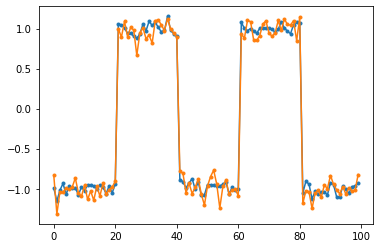

In [11]:
# Problem formulation
# state process setup
Time = 10.
dt = 0.1
num_dim = 1
X_initial = -1 + torch.randn(1) * 0.02
N_T = int(Time//dt+1)
t_path = np.linspace(0, Time, N_T)
sigma_SDE = 0.2


#dt = t_path[1] - t_path[0]


X_path = torch.zeros((N_T, num_dim))
X_path[0] = X_initial.clone()
x_new = X_initial.clone()

for i in range(N_T-1):
    # Generate true state trajectory
    x_old = X_path[i]
    
    x_new[0] = x_old[0] - 4*x_old[0]*(x_old[0]**2 - 1)*dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
    
    X_path[i+1] = x_new
    
    if i==20:
        X_path[i+1] = -X_path[i+1]
    if i==40:
        X_path[i+1] = -X_path[i+1]
    if i==60:
        X_path[i+1] = -X_path[i+1]
    if i==80:
        X_path[i+1] = -X_path[i+1]
    
# plt.plot(*X_path.T, '.-')
# plt.title('state')
# plt.show()

# get observation
sigma_obs = 0.1

obs_path_true = X_path
obs_path = obs_path_true + np.random.randn(N_T,num_dim)*sigma_obs

# plot
plt.plot(X_path,'.-',label='state')
plt.plot(obs_path,'.-',label='obs')
plt.show()

In [12]:
# initial guess
x0 = torch.tensor(X_initial.clone(), dtype=torch.float32, device=device)
sigma0 = 0.2

print(X_initial)


tensor([-0.9912])


C:\Users\10576\AppData\Local\Temp\ipykernel_14456\3694373087.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(X_initial.clone(), dtype=torch.float32, device=device)


In [13]:
# Training initialize
x_dim = num_dim
hidden_depth  = 2
embed_dim = 50
use_bn = False

score_prior_old = ScoreNet(marginal_prob_std=marginal_prob_std_fn, x_dim=x_dim,
                           hidden_depth=hidden_depth, embed_dim=embed_dim, use_bn=use_bn)

score_prior_new = ScoreNet(marginal_prob_std=marginal_prob_std_fn, x_dim=x_dim,
                           hidden_depth=hidden_depth, embed_dim=embed_dim, use_bn=use_bn)

score_prior_old = score_prior_old.to(device)
score_prior_new = score_prior_new.to(device)

# initial samples
sample_size = 1000
x_init = x0 + torch.randn(sample_size,num_dim, dtype=torch.float32, device=device)*sigma0
train_loss = train_model(score_prior_old, x_sample=x_init, batch_size=sample_size, lr=0.005, n_epochs=600, print_interval=100)

likelihood_score_fn = None
score_prior_new = score_prior_old

epoch: 0	 loss: 3.224475622177124
epoch: 100	 loss: 0.22057612240314484
epoch: 200	 loss: 0.1149153858423233
epoch: 300	 loss: 0.09554843604564667
epoch: 400	 loss: 0.07647322863340378
epoch: 500	 loss: 0.08386338502168655


In [14]:
est_all = []
x_prior = x_init.clone()
for i in range(N_T-1):
    print(i)
    
    score_prior_old = score_prior_new
    score_prior_new = copy.deepcopy(score_prior_new)
    
    # sample initial distribution
    x_init = Euler_Maruyama_sampler(score_prior_old,marginal_prob_std_fn, diffusion_coeff_fn,score_likelihood=likelihood_score_fn,
                                   batch_size=sample_size,num_steps=600,device=device)
    est_all.append(torch.mean(x_init, dim=0).cpu().numpy())


    # solve for forward SDE (prediction)
    x_prior[:,0] = x_init[:,0] - 4 * x_init[:,0] * ( x_init[:,0]**2 - 1)*dt + torch.randn(sample_size,device=device) * np.sqrt(dt)


    print('est: ',est_all[i])
    print('state: ',X_path[i])


    # train model for prior distribution
    train_loss = train_model(score_prior_new, x_sample=x_prior,
                             batch_size=sample_size,lr=0.01, n_epochs=600, print_interval=200)

    # new observation
    obs_current = np.array(obs_path[i+1,:])

    # update likelihood function
    likelihood_score_fn = functools.partial(likelihood_score, obs=obs_current, sigma_obs=sigma_obs)
    # likelihood_score_fn = functools.partial(likelihood_score_damp, obs=obs_current, sigma_obs=sigma_obs, c=0.1)
    # next iteration


# last estimation
# sample initial distribution
x_init = Euler_Maruyama_sampler(score_prior_old,marginal_prob_std_fn, diffusion_coeff_fn,score_likelihood=likelihood_score_fn,
                               batch_size=sample_size,num_steps=500,device=device)
est_all.append(torch.mean(x_init, dim=0).cpu().numpy())

#
est_all = np.array(est_all)


0


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.01298]
state:  tensor([-0.9912])
epoch: 0	 loss: 0.17819209396839142
epoch: 200	 loss: 0.14945904910564423
epoch: 400	 loss: 0.14128872752189636
1


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.2522938]
state:  tensor([-1.1557])
epoch: 0	 loss: 0.13849380612373352
epoch: 200	 loss: 0.12137648463249207
epoch: 400	 loss: 0.11966647952795029
2


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0287669]
state:  tensor([-1.0194])
epoch: 0	 loss: 0.12964367866516113
epoch: 200	 loss: 0.14360101521015167
epoch: 400	 loss: 0.10272470861673355
3


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0433372]
state:  tensor([-0.9351])
epoch: 0	 loss: 0.1573639065027237
epoch: 200	 loss: 0.13998332619667053
epoch: 400	 loss: 0.1459709107875824
4


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9930827]
state:  tensor([-1.0706])
epoch: 0	 loss: 0.11329317092895508
epoch: 200	 loss: 0.12389975786209106
epoch: 400	 loss: 0.13890360295772552
5


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.01701]
state:  tensor([-0.9645])
epoch: 0	 loss: 0.11347368359565735
epoch: 200	 loss: 0.14075180888175964
epoch: 400	 loss: 0.1326887011528015
6


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9731242]
state:  tensor([-0.9922])
epoch: 0	 loss: 0.13610923290252686
epoch: 200	 loss: 0.12565480172634125
epoch: 400	 loss: 0.11777951568365097
7


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.8822499]
state:  tensor([-0.9902])
epoch: 0	 loss: 0.12653250992298126
epoch: 200	 loss: 0.12244126200675964
epoch: 400	 loss: 0.1144396960735321
8


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0446361]
state:  tensor([-1.0755])
epoch: 0	 loss: 0.13032683730125427
epoch: 200	 loss: 0.13672205805778503
epoch: 400	 loss: 0.11265676468610764
9


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0862732]
state:  tensor([-0.9804])
epoch: 0	 loss: 0.11501697450876236
epoch: 200	 loss: 0.12176834046840668
epoch: 400	 loss: 0.14826709032058716
10


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.96138394]
state:  tensor([-1.0282])
epoch: 0	 loss: 0.1190316453576088
epoch: 200	 loss: 0.12074229121208191
epoch: 400	 loss: 0.11879535764455795
11


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1129268]
state:  tensor([-0.9500])
epoch: 0	 loss: 0.11817009747028351
epoch: 200	 loss: 0.12315276265144348
epoch: 400	 loss: 0.10891766846179962
12


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0305647]
state:  tensor([-0.9597])
epoch: 0	 loss: 0.147029846906662
epoch: 200	 loss: 0.12908393144607544
epoch: 400	 loss: 0.11754704266786575
13


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.136038]
state:  tensor([-0.9679])
epoch: 0	 loss: 0.12641340494155884
epoch: 200	 loss: 0.13213224709033966
epoch: 400	 loss: 0.12796318531036377
14


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9694366]
state:  tensor([-1.0017])
epoch: 0	 loss: 0.1184530258178711
epoch: 200	 loss: 0.12589842081069946
epoch: 400	 loss: 0.11005868762731552
15


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0858757]
state:  tensor([-0.9586])
epoch: 0	 loss: 0.10364781320095062
epoch: 200	 loss: 0.12631595134735107
epoch: 400	 loss: 0.12746189534664154
16


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9422077]
state:  tensor([-0.9776])
epoch: 0	 loss: 0.11043769121170044
epoch: 200	 loss: 0.12371307611465454
epoch: 400	 loss: 0.13037830591201782
17


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0489933]
state:  tensor([-1.0633])
epoch: 0	 loss: 0.11280615627765656
epoch: 200	 loss: 0.12366323173046112
epoch: 400	 loss: 0.127466082572937
18


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0199753]
state:  tensor([-0.9645])
epoch: 0	 loss: 0.12009207904338837
epoch: 200	 loss: 0.12717869877815247
epoch: 400	 loss: 0.14125841856002808
19


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.970258]
state:  tensor([-1.0516])
epoch: 0	 loss: 0.11388673633337021
epoch: 200	 loss: 0.11890395730733871
epoch: 400	 loss: 0.1255320906639099
20


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9246511]
state:  tensor([-0.9420])
epoch: 0	 loss: 0.11851569265127182
epoch: 200	 loss: 0.11175604164600372
epoch: 400	 loss: 0.12899869680404663
21


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.79591113]
state:  tensor([1.0559])
epoch: 0	 loss: 2.1756365299224854
epoch: 200	 loss: 0.10797111690044403
epoch: 400	 loss: 0.119136281311512
22


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.89484024]
state:  tensor([1.0474])
epoch: 0	 loss: 0.11904872208833694
epoch: 200	 loss: 0.13181710243225098
epoch: 400	 loss: 0.13893002271652222
23


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.077711]
state:  tensor([1.0089])
epoch: 0	 loss: 0.1211063414812088
epoch: 200	 loss: 0.12794266641139984
epoch: 400	 loss: 0.10290896147489548
24


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.9044529]
state:  tensor([0.9388])
epoch: 0	 loss: 0.10533766448497772
epoch: 200	 loss: 0.11506613343954086
epoch: 400	 loss: 0.1167437881231308
25


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0201187]
state:  tensor([0.9472])
epoch: 0	 loss: 0.13082535564899445
epoch: 200	 loss: 0.12462230026721954
epoch: 400	 loss: 0.11902116984128952
26


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.9767867]
state:  tensor([0.9022])
epoch: 0	 loss: 0.11938144266605377
epoch: 200	 loss: 0.11615487188100815
epoch: 400	 loss: 0.1367449313402176
27


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.6800195]
state:  tensor([0.8771])
epoch: 0	 loss: 0.13880713284015656
epoch: 200	 loss: 0.13979309797286987
epoch: 400	 loss: 0.1216379851102829
28


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.9404236]
state:  tensor([0.9322])
epoch: 0	 loss: 0.149665966629982
epoch: 200	 loss: 0.13710030913352966
epoch: 400	 loss: 0.11905479431152344
29


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0065972]
state:  tensor([1.0536])
epoch: 0	 loss: 0.12819477915763855
epoch: 200	 loss: 0.13403943181037903
epoch: 400	 loss: 0.13401910662651062
30


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.889206]
state:  tensor([0.9729])
epoch: 0	 loss: 0.11014656722545624
epoch: 200	 loss: 0.11562751978635788
epoch: 400	 loss: 0.11870033293962479
31


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.92510444]
state:  tensor([1.0905])
epoch: 0	 loss: 0.12754569947719574
epoch: 200	 loss: 0.11242787539958954
epoch: 400	 loss: 0.11716651171445847
32


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.8339977]
state:  tensor([1.0391])
epoch: 0	 loss: 0.1257690191268921
epoch: 200	 loss: 0.12164134532213211
epoch: 400	 loss: 0.11806156486272812
33


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0880548]
state:  tensor([1.0776])
epoch: 0	 loss: 0.1407424956560135
epoch: 200	 loss: 0.15814080834388733
epoch: 400	 loss: 0.13042132556438446
34


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0998533]
state:  tensor([1.0148])
epoch: 0	 loss: 0.1589278280735016
epoch: 200	 loss: 0.1475316882133484
epoch: 400	 loss: 0.09904804080724716
35


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0455995]
state:  tensor([0.9582])
epoch: 0	 loss: 0.12781871855258942
epoch: 200	 loss: 0.11426638811826706
epoch: 400	 loss: 0.1298884153366089
36


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.9763422]
state:  tensor([0.9773])
epoch: 0	 loss: 0.13670599460601807
epoch: 200	 loss: 0.13801702857017517
epoch: 400	 loss: 0.14382170140743256
37


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.1105684]
state:  tensor([1.1540])
epoch: 0	 loss: 0.12240058928728104
epoch: 200	 loss: 0.13803525269031525
epoch: 400	 loss: 0.11318770051002502
38


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0051011]
state:  tensor([0.9799])
epoch: 0	 loss: 0.14120692014694214
epoch: 200	 loss: 0.10542839765548706
epoch: 400	 loss: 0.12337283790111542
39


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.9345849]
state:  tensor([0.9366])
epoch: 0	 loss: 0.13011562824249268
epoch: 200	 loss: 0.12715113162994385
epoch: 400	 loss: 0.13033537566661835
40


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.90849876]
state:  tensor([0.9027])
epoch: 0	 loss: 0.13205954432487488
epoch: 200	 loss: 0.14037127792835236
epoch: 400	 loss: 0.12489689886569977
41


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.65375715]
state:  tensor([-0.8865])
epoch: 0	 loss: 1.891226053237915
epoch: 200	 loss: 0.13553045690059662
epoch: 400	 loss: 0.11736726760864258
42


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.80858064]
state:  tensor([-0.9115])
epoch: 0	 loss: 0.12672583758831024
epoch: 200	 loss: 0.11882820725440979
epoch: 400	 loss: 0.13202722370624542
43


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0393858]
state:  tensor([-0.9904])
epoch: 0	 loss: 0.1447065770626068
epoch: 200	 loss: 0.12418147921562195
epoch: 400	 loss: 0.1352168172597885
44


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.942254]
state:  tensor([-0.9301])
epoch: 0	 loss: 0.11628380417823792
epoch: 200	 loss: 0.12976433336734772
epoch: 400	 loss: 0.10873575508594513
45


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0562153]
state:  tensor([-0.8755])
epoch: 0	 loss: 0.11126220226287842
epoch: 200	 loss: 0.12608087062835693
epoch: 400	 loss: 0.13065935671329498
46


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9821083]
state:  tensor([-1.0083])
epoch: 0	 loss: 0.13389694690704346
epoch: 200	 loss: 0.11602672934532166
epoch: 400	 loss: 0.1312139928340912
47


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.88851947]
state:  tensor([-0.9193])
epoch: 0	 loss: 0.11294428259134293
epoch: 200	 loss: 0.12314089387655258
epoch: 400	 loss: 0.11270346492528915
48


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0656453]
state:  tensor([-1.0840])
epoch: 0	 loss: 0.1330839842557907
epoch: 200	 loss: 0.1358702927827835
epoch: 400	 loss: 0.13423185050487518
49


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1833863]
state:  tensor([-1.0782])
epoch: 0	 loss: 0.1399957239627838
epoch: 200	 loss: 0.13321568071842194
epoch: 400	 loss: 0.12924060225486755
50


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.97940785]
state:  tensor([-0.9493])
epoch: 0	 loss: 0.10890480875968933
epoch: 200	 loss: 0.10856232792139053
epoch: 400	 loss: 0.1328575313091278
51


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.8653167]
state:  tensor([-0.9558])
epoch: 0	 loss: 0.1385633498430252
epoch: 200	 loss: 0.11306051164865494
epoch: 400	 loss: 0.10371079295873642
52


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.78881127]
state:  tensor([-0.9584])
epoch: 0	 loss: 0.1089932844042778
epoch: 200	 loss: 0.13209323585033417
epoch: 400	 loss: 0.14204056560993195
53


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9399022]
state:  tensor([-0.9704])
epoch: 0	 loss: 0.1247069239616394
epoch: 200	 loss: 0.11413445323705673
epoch: 400	 loss: 0.11164335906505585
54


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.2176435]
state:  tensor([-0.9665])
epoch: 0	 loss: 0.11573819816112518
epoch: 200	 loss: 0.11038709431886673
epoch: 400	 loss: 0.12409273535013199
55


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9827629]
state:  tensor([-0.9473])
epoch: 0	 loss: 0.12182080745697021
epoch: 200	 loss: 0.12419740110635757
epoch: 400	 loss: 0.13940151035785675
56


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.8995751]
state:  tensor([-0.9154])
epoch: 0	 loss: 0.14170782268047333
epoch: 200	 loss: 0.12732678651809692
epoch: 400	 loss: 0.12890195846557617
57


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0596988]
state:  tensor([-1.0652])
epoch: 0	 loss: 0.12484560161828995
epoch: 200	 loss: 0.11897852271795273
epoch: 400	 loss: 0.1406625211238861
58


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0234346]
state:  tensor([-0.9847])
epoch: 0	 loss: 0.14977869391441345
epoch: 200	 loss: 0.10052572190761566
epoch: 400	 loss: 0.11896232515573502
59


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0006111]
state:  tensor([-1.0226])
epoch: 0	 loss: 0.12487839162349701
epoch: 200	 loss: 0.10371268540620804
epoch: 400	 loss: 0.12724943459033966
60


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0685462]
state:  tensor([-1.0090])
epoch: 0	 loss: 0.13787619769573212
epoch: 200	 loss: 0.13809584081172943
epoch: 400	 loss: 0.11429169028997421
61


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.7284994]
state:  tensor([1.0776])
epoch: 0	 loss: 2.1033623218536377
epoch: 200	 loss: 0.10906592011451721
epoch: 400	 loss: 0.1119554191827774
62


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.88126457]
state:  tensor([1.0021])
epoch: 0	 loss: 0.11862709373235703
epoch: 200	 loss: 0.14062923192977905
epoch: 400	 loss: 0.12259677797555923
63


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0864968]
state:  tensor([0.9736])
epoch: 0	 loss: 0.136334627866745
epoch: 200	 loss: 0.12232659012079239
epoch: 400	 loss: 0.12594489753246307
64


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.071187]
state:  tensor([1.0008])
epoch: 0	 loss: 0.11930420994758606
epoch: 200	 loss: 0.11200980097055435
epoch: 400	 loss: 0.12480530142784119
65


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.86203253]
state:  tensor([0.9693])
epoch: 0	 loss: 0.12234687060117722
epoch: 200	 loss: 0.13995057344436646
epoch: 400	 loss: 0.13568134605884552
66


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.85829234]
state:  tensor([0.9412])
epoch: 0	 loss: 0.1271563172340393
epoch: 200	 loss: 0.12381772696971893
epoch: 400	 loss: 0.11859508603811264
67


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.9219394]
state:  tensor([1.0037])
epoch: 0	 loss: 0.1137133538722992
epoch: 200	 loss: 0.11422954499721527
epoch: 400	 loss: 0.11042477935552597
68


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0412322]
state:  tensor([1.0115])
epoch: 0	 loss: 0.14326933026313782
epoch: 200	 loss: 0.1403193175792694
epoch: 400	 loss: 0.11258117109537125
69


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0880176]
state:  tensor([1.0017])
epoch: 0	 loss: 0.13366366922855377
epoch: 200	 loss: 0.12918780744075775
epoch: 400	 loss: 0.11603125184774399
70


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.94630265]
state:  tensor([1.0056])
epoch: 0	 loss: 0.11056166887283325
epoch: 200	 loss: 0.1126430556178093
epoch: 400	 loss: 0.14426939189434052
71


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.9046547]
state:  tensor([0.9937])
epoch: 0	 loss: 0.11737325042486191
epoch: 200	 loss: 0.11435522139072418
epoch: 400	 loss: 0.12931622564792633
72


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.94438666]
state:  tensor([0.9511])
epoch: 0	 loss: 0.13376428186893463
epoch: 200	 loss: 0.11645491421222687
epoch: 400	 loss: 0.14302393794059753
73


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0843643]
state:  tensor([0.9890])
epoch: 0	 loss: 0.12450742721557617
epoch: 200	 loss: 0.11518621444702148
epoch: 400	 loss: 0.10889732837677002
74


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.97019583]
state:  tensor([1.0849])
epoch: 0	 loss: 0.1202116459608078
epoch: 200	 loss: 0.12100913375616074
epoch: 400	 loss: 0.13360807299613953
75


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.1038336]
state:  tensor([1.0085])
epoch: 0	 loss: 0.13491058349609375
epoch: 200	 loss: 0.12419939041137695
epoch: 400	 loss: 0.1375022530555725
76


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0481974]
state:  tensor([0.9667])
epoch: 0	 loss: 0.11352141201496124
epoch: 200	 loss: 0.10768584907054901
epoch: 400	 loss: 0.11464047431945801
77


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.027233]
state:  tensor([0.9360])
epoch: 0	 loss: 0.14559894800186157
epoch: 200	 loss: 0.14533783495426178
epoch: 400	 loss: 0.1148630902171135
78


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0867947]
state:  tensor([1.0483])
epoch: 0	 loss: 0.1392046958208084
epoch: 200	 loss: 0.13618652522563934
epoch: 400	 loss: 0.1012570932507515
79


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.8697427]
state:  tensor([1.0871])
epoch: 0	 loss: 0.1158079206943512
epoch: 200	 loss: 0.1314719021320343
epoch: 400	 loss: 0.11491244286298752
80


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.1195909]
state:  tensor([1.0638])
epoch: 0	 loss: 0.14763036370277405
epoch: 200	 loss: 0.14002688229084015
epoch: 400	 loss: 0.11513633280992508
81


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.99214983]
state:  tensor([-1.0548])
epoch: 0	 loss: 2.322819709777832
epoch: 200	 loss: 0.12598755955696106
epoch: 400	 loss: 0.10330630838871002
82


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0127841]
state:  tensor([-0.9084])
epoch: 0	 loss: 0.1128210797905922
epoch: 200	 loss: 0.11604609340429306
epoch: 400	 loss: 0.11361948400735855
83


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0376219]
state:  tensor([-0.9428])
epoch: 0	 loss: 0.1461455076932907
epoch: 200	 loss: 0.1416831612586975
epoch: 400	 loss: 0.1349787712097168
84


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.2144804]
state:  tensor([-1.1274])
epoch: 0	 loss: 0.13551481068134308
epoch: 200	 loss: 0.1412976235151291
epoch: 400	 loss: 0.145590141415596
85


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0466733]
state:  tensor([-1.0331])
epoch: 0	 loss: 0.13350997865200043
epoch: 200	 loss: 0.117398202419281
epoch: 400	 loss: 0.10722040385007858
86


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0157686]
state:  tensor([-1.0703])
epoch: 0	 loss: 0.12602348625659943
epoch: 200	 loss: 0.11343659460544586
epoch: 400	 loss: 0.11528107523918152
87


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1001348]
state:  tensor([-1.0478])
epoch: 0	 loss: 0.13476328551769257
epoch: 200	 loss: 0.12718841433525085
epoch: 400	 loss: 0.13172510266304016
88


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.96289885]
state:  tensor([-1.0394])
epoch: 0	 loss: 0.12525323033332825
epoch: 200	 loss: 0.130917489528656
epoch: 400	 loss: 0.11969275772571564
89


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9990348]
state:  tensor([-1.0787])
epoch: 0	 loss: 0.12826114892959595
epoch: 200	 loss: 0.10266614705324173
epoch: 400	 loss: 0.09010375291109085
90


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.8556928]
state:  tensor([-0.9243])
epoch: 0	 loss: 0.1184324249625206
epoch: 200	 loss: 0.1208527609705925
epoch: 400	 loss: 0.11201900243759155
91


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9505685]
state:  tensor([-0.9504])
epoch: 0	 loss: 0.13063208758831024
epoch: 200	 loss: 0.12372735887765884
epoch: 400	 loss: 0.10615604370832443
92


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.008326]
state:  tensor([-1.1028])
epoch: 0	 loss: 0.11477311700582504
epoch: 200	 loss: 0.11773525178432465
epoch: 400	 loss: 0.13454940915107727
93


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0708882]
state:  tensor([-1.1012])
epoch: 0	 loss: 0.12111280858516693
epoch: 200	 loss: 0.10547640174627304
epoch: 400	 loss: 0.12276016920804977
94


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9774705]
state:  tensor([-0.9707])
epoch: 0	 loss: 0.1195158138871193
epoch: 200	 loss: 0.10837510973215103
epoch: 400	 loss: 0.13670247793197632
95


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0651692]
state:  tensor([-1.0045])
epoch: 0	 loss: 0.10371431708335876
epoch: 200	 loss: 0.12764286994934082
epoch: 400	 loss: 0.1294718235731125
96


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.98627955]
state:  tensor([-1.0595])
epoch: 0	 loss: 0.12877631187438965
epoch: 200	 loss: 0.13865934312343597
epoch: 400	 loss: 0.13716500997543335
97


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0237186]
state:  tensor([-0.9752])
epoch: 0	 loss: 0.11380433291196823
epoch: 200	 loss: 0.11719493567943573
epoch: 400	 loss: 0.12057839334011078
98


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.01189]
state:  tensor([-0.9639])
epoch: 0	 loss: 0.1152620017528534
epoch: 200	 loss: 0.12815876305103302
epoch: 400	 loss: 0.08956413716077805


  0%|          | 0/500 [00:00<?, ?it/s]

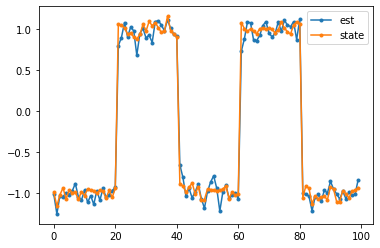

In [15]:
plt.plot(est_all,'.-',label='est')
plt.plot(X_path,'.-',label='state')
plt.legend()
plt.show()

In [46]:
np.savetxt('Est_all.txt', est_all)
np.savetxt('X_path.txt', X_path)
np.savetxt('obs_path.txt', obs_path)
